In [1]:
import os.path as osp

import torch

from models import HGT
from util import DBLP
from explainer import HeterExplainer

In [2]:
dataset_name = 'DBLP'
dataset = DBLP('data/'+dataset_name)
data = dataset[0]
print('WARNING: the dataset is re-processed for the bag-of-word map') # reconstructed dataset: author-dim 451, paper-dim 4233
print(data)

data['conference'].x = torch.ones(data['conference'].num_nodes, 1)

n_types = data.metadata()[0]
n_types.remove('term')
e_types = [edge for edge in data.metadata()[1] if 'term' not in edge]
e_types_to_remove = [edge for edge in data.metadata()[1] if 'term' in edge]
meta = tuple([n_types, e_types])

### fix Linear -1 dim error
node_types = {node_type:data[node_type].x.size(1) for node_type in n_types}

x_dict = data.x_dict
x_dict.pop('term')
edge_index_dict = data.edge_index_dict
for e in e_types_to_remove:
    edge_index_dict.pop(e)

HeteroData(
  author={
    x=[4057, 451],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057]
  },
  paper={ x=[14328, 4233] },
  term={ x=[7723, 50] },
  conference={ num_nodes=20 },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


In [3]:
hidden_channels=64
out_channels=4
num_heads=2
num_layers=2

ckpt_name = '_'.join((dataset_name, 'inDim', str(hidden_channels), 'nHead', str(num_heads),'nLayer', str(num_layers)))
ckpt_name+='_noTerm'

ckpt_path = 'checkpoints/'+ckpt_name+'.pt'
model = HGT(hidden_channels=hidden_channels, out_channels=out_channels, num_heads=num_heads, num_layers=num_layers, node_types=node_types, metadata = meta)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data, model = data.to(device), model.to(device)

checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint['net'])


<All keys matched successfully>

Explainer (heter) set up on cpu
P1051: Factorization In Experiment Generation.
P2171: Finding Highly Correlated Pairs Efficiently With Powerful Pruning.



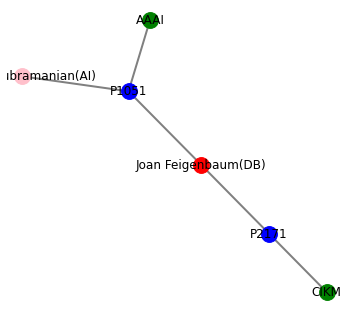

Generating 1000 samples on target: 958
F^Hence-X
F-effect: 0.9986483454704285 O-Dens: 0.13333333333333333   T-Dens: 0.16666666666666666  F-Dens: 0.8
Author(s) and paper(s) in the factual explanation:
9580
[0 'Joan Feigenbaum']
['generation' 'experiment' 'efficiently' 'pruning']
CF^Hence-X
CF-effect: 0.9991315856750589 O-Dens: 0.13333333333333333   T-Dens: 0.16666666666666666  F-Dens: 0.8
Author(s) and paper(s) in the counterfactual explanation:
9580
[0 'Joan Feigenbaum']
['generation' 'experiment' 'efficiently' 'pruning']


In [4]:
explainer = HeterExplainer(model, dataset_name, x_dict=x_dict, edge_index_dict=edge_index_dict, device=device)

num_samples = 1000
p_threshold = .05
p_perturb = 0.5
pred_threshold = .01 # sigma in Equation (2)
k = 10

zero_feature_cases = (data['author'].x.sum(dim=-1)==0).nonzero().cpu().numpy().T[0].tolist()
test_case = [i for i in range(data['author'].num_nodes) if i not in zero_feature_cases]

target = 958 # example used in the paper
explainer.draw_DBLP(target, if_save=False, name='original')

S, raw_feature_exp, feature_exp, time_used = explainer.explain(target, num_samples=num_samples, k=k, p_perturb=p_perturb, p_threshold=p_threshold, pred_threshold=pred_threshold)

factual_S, factual_feat_exp = explainer.factual_synMLE(target, S, raw_feature_exp, num_samples=num_samples, k=k, p_perturb=p_perturb)
F_metric = explainer.calFidelity(target, factual_S, factual_feat_exp)
print(f"\nF^Hence-X\nF-effect: {F_metric[2]} O-Dens: {F_metric[3]}   T-Dens: {F_metric[4]}  F-Dens: {F_metric[5]}")
# explainer.draw_DBLP(target, S=factual_S, if_save=False, name='factual_exp')
print('Author(s) and paper(s) in the factual explanation:')
explainer.printMeaningDBLP(factual_S, factual_feat_exp)


counterfactual_S, counterfactual_feat_exp = explainer.counterfactual_synMLE(target, S, raw_feature_exp, num_samples=num_samples, k=k, p_perturb=p_perturb)
CF_metric = explainer.calFidelity(target, counterfactual_S, counterfactual_feat_exp)
print(f"\nCF^Hence-X\nCF-effect: {CF_metric[0]} O-Dens: {CF_metric[3]}   T-Dens: {CF_metric[4]}  F-Dens: {CF_metric[5]}")
# explainer.draw_DBLP(target, S=conterfactual_S, if_save=False, name='conterfactual_exp')
print('Author(s) and paper(s) in the counterfactual explanation:')
explainer.printMeaningDBLP(counterfactual_S, counterfactual_feat_exp)
